# IACV Exercise 5: Transfer Learning

**Deadline: 23 December 2022, 11:59 PM**  
**Covered Topics: Lecture 9-10**

In this exercise, you will again tackle the image classification task, as in exercise 4. Given an input RGB image with resolution `(32, 32, 3)`, you need to predict which of the 10 input classes it belongs to. However, unlike in exercise 4, you have access to limited training data in `training.h5`. In fact, you only have `210` samples per class, which are separated into training, validation, and test sets of ratio `7:1:2` for ease of use. You can use these three sets of data for your development.

**Note that the real test data you should evaluate your model has `1000` images without labels and can be found in `test.h5`.** 

Fortunately, you have access to a pre-trained network which has been trained on large amounts of data to classify 5 out of 10 input classes. That is, the pre-trained network obtains a classification accuracy of around 95% for 5 of the classes, while the remaining classes are not defined at all. Its parameters are defined in `resnet4five.pt` and the loading process explained in **Load pre-trained model** below.

Your task is to either adapt this model, or train a new network from scratch which can classify all 10 classes.

**Note:** Similar to exercise 4, we will use the [PyTorch](https://https://pytorch.org/) deep learning framework in this exercise. Thus we highly recommend going through exercise 4 first before starting with this exercise.

**Evaluation Criteria**

Your algorithm will be evaluated using classification accuracy, which is the proportion of images with the correct predicted label.
The final EvaluationScore is obtained as the classification accuracy over all test samples, over all 10 classes.

**Passing requirement**

Your algorithm will be evaluated on a test set. In order to pass the exercise, you need to obtain an EvaluationScore of **greater than $60.0$** on the test set.

Follow the steps in the rest of the notebook to generate the submission. The evaluation server for the exercise is at https://codalab.lisn.upsaclay.fr/competitions/9001. The notebook also contains an additional tutorial on some deep learning operations with PyTorch, which you may find useful to complete the exercise.



In [52]:
# These two lines ensure that we always import the latest version of a package, 
# in case it has been modified.
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import csv
import cv2
import os
import numpy as np
import random
import shutil

import sys
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
iacv_path = 'MyDrive/Colab Notebooks/ICV/ex5'

from google.colab import drive
drive.mount('/content/drive')

env_path = f'/content/drive/{iacv_path}'
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(env_path)

# Create folder to store checkpoints
os.makedirs(f"{env_path}/ckpt", exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
if torch.cuda.is_available():
    print("CUDA available! GPU will be used for training.")
    device = torch.device("cuda")
else:
    print("CUDA not available! CPU will be used for training.")
    device = torch.device("cpu")


CUDA available! GPU will be used for training.


Define a mapping from 5 to 10 classes because the indices do not match, such as `classes[0]` is `Airplane` while `classes5[0]` is `Cat`

In [55]:
# Mapping from 5 to 10 classes

# Classes for the pretrained dataset
classes5 = ["Cat", "Deer", "Frog", "Ship", "Truck"]

# Actual classes
classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", 
           "Dog", "Frog", "Horse", "Ship", "Truck"]

# Converting numpy arrays for indexing
classes5 = np.array(classes5)
classes = np.array(classes)

# Mapping from 5 classes to 10 classes for evaluation
map5to10 = [np.where(classes==class_)[0][0] for class_ in classes5]
map5to10 = np.array(map5to10)
print("Mapping array is:", map5to10)

Mapping array is: [3 4 6 8 9]


In [56]:
# Example usage

# Random predictions by 5
preds5 = np.random.randint(5, size=7, dtype=int)

# Predicted classes
print("Actual Predictions:        ", classes5[preds5])

# Wrong mapping from 5 to 10 classes
print("Wrongly-mapped Predictions:", classes[preds5])

# Correct mapping from 5 to 10 classes
print("Correct-mapped Predictions:", classes[map5to10[preds5]])

Actual Predictions:         ['Deer' 'Frog' 'Frog' 'Cat' 'Deer' 'Cat' 'Frog']
Wrongly-mapped Predictions: ['Automobile' 'Bird' 'Bird' 'Airplane' 'Automobile' 'Airplane' 'Bird']
Correct-mapped Predictions: ['Deer' 'Frog' 'Frog' 'Cat' 'Deer' 'Cat' 'Frog']


Define the plotting functions to visualize the images and predictions

In [57]:
# class labels. This provides the mapping from the integer label for 
# an image to a descriptive name

# function to show image
def show_images(ims, gt_labels, pred_labels=None):
    fig, ax = plt.subplots(1, len(ims), figsize=(12, 12))
    for id in range(len(ims)):
        im = ims[id]
        im = im / 2 + 0.5     # unnormalize
        im_np = im.numpy()

        ax[id].imshow(np.transpose(im_np, (1, 2, 0)))

        if pred_labels is None:
            im_title = f'GT: {classes[gt_labels[id]]}'
        else:
            im_title = f'GT: {classes[gt_labels[id]]}  '
            im_title += f' Pred: {classes[pred_labels[id]]}'
        ax[id].set_title(im_title)
    plt.show()


In [58]:
from dataset import get_datasets_from_h5, get_loaders_from_datasets

# Get the datasets
dataset_path = f'{env_path}/training.h5'

train_dataset, val_dataset, test_dataset = get_datasets_from_h5(dataset_path)

# Construct the dataloaders
batch_size = 5     # Feel free to change this
train_loader, val_loader, test_loader = \
    get_loaders_from_datasets(train_dataset, val_dataset, test_dataset, 
                              batch_size)

# Create the model and summarize
num_classes = train_dataset.num_classes
input_size = train_dataset.image_size

# Print the sizes of the datasets
print(f"The dataset contains {train_dataset.num_classes} classes.")
print(f"Number of images in each dataset: Training={len(train_dataset)}, ", 
      f"Validation={len(val_dataset)}, Test={len(test_dataset)}")


The dataset contains 10 classes.
Number of images in each dataset: Training=1470,  Validation=210, Test=420


Visualize a few training samples along with the ground truth labels to get an idea of how the images look. You can run this multiple times to check different images

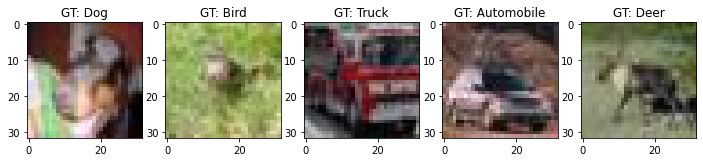

In [59]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# print(labels)
show_images(images[:10], labels[:10])

## Load pre-trained model

As mentioned before, you have access to parameters of a pre-trained model `resnet4five.pt`, which is a standard ResNet18 model and has been trained to classify images into 5 classes ("Cat", "Deer", "Frog", "Ship", "Truck"), using larger dataset. It achieves accuracy of higher than 90% for these classes.

In [60]:
import torch
from model import generate_resnet

load_path = f'{env_path}/resnet4five.pt'     # Path to load the model from

# Create the model and summarize it. Note that the model has been trained to
# classify only 5 classes
num_classes = 5
model = generate_resnet(num_classes=num_classes) # Generate the resnet18 model

# Next we load the pre-trained weights, and set it to the model we created
model.load_state_dict(torch.load(load_path, map_location=torch.device(device)))

<All keys matched successfully>

Next, we can test the pre-trained model on the dataset.

In [61]:
from evaluation import evaluate_model

# Evaluate the model
val_accuracy = evaluate_model(model, val_loader, device=device, 
                              mapping=map5to10)
print(f"Validation accuracy with pretrained model: {val_accuracy:.3f}")
test_accuracy = evaluate_model(model, test_loader, device=device, 
                               mapping=map5to10)
print(f"Test accuracy with pretrained model: {test_accuracy:.3f}")

Validation accuracy with pretrained model: 0.448
Test accuracy with pretrained model: 0.476


To further analyse the performance, we will look at the the classification accuracy per-class.

Define a plotting function for per-class accuracies.

In [62]:
# show class-based accuracies

def show_class_accs(accs_dict, class_names=None, title=" "):

    accs, names = list(), list()
    for key, value in accs_dict.items():
        name = class_names[key] if class_names is not None else str(key)
        names.append(name)
        accs.append(value)

    y_pos = np.arange(len(names))

    fig, ax = plt.subplots()

    hbars = ax.barh(y_pos, accs, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Accuracy')
    ax.set_title(title)

    plt.show()


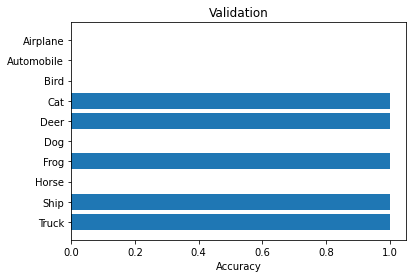

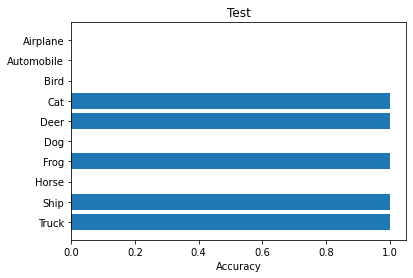

In [63]:
from evaluation import evaluate_model

# Classwise Accuracies
val_class_accs = evaluate_model(model, val_loader, device=device, 
                              mapping=map5to10, classwise=True)

show_class_accs(val_class_accs, classes, title="Validation")

test_class_accs = evaluate_model(model, test_loader, device=device, 
                               mapping=map5to10, classwise=True)

show_class_accs(val_class_accs, classes, title="Test")

As expected, we see the the pre-trained model obtains good performance on the 5 out of 10 classes which it has been trained for. However, it cannot handle the other 5 *unseen* classes, and thus obtains a low overall classification accuracy. Your task is to adapt this pre-trained model such that it obtains better overall classification accuracy, i.e. > 60%.

## Rules and Submission

Throughout this project, you are **not allowed to use any other dataset and/or pre-trained model other than the given ones**. You are allowed to use any other techniques you have learned in the course, including but not limited to *data augmentation, early stopping, and transfer learning*. In order to receive full credit, you are expected to use a model that can classify images into the 10 classes defined in `test.h5` **with an accuracy of at least 60.0%**. An example submission using an untrained model can be seen in the Python cell below.

In [64]:
model = generate_resnet(num_classes=5)
model.load_state_dict(torch.load(load_path, map_location=torch.device(device)))
model.linear = torch.nn.Linear(512, 10)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [74]:
import time
import copy


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataset_sizes = {'train': len(train_loader), 'val': len(val_loader)}
    dataloaders = {'train': train_loader, 'val': val_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, loss_fn, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 9.8216 Acc: 1.2381
val Loss: 7.2108 Acc: 3.4524

Epoch 1/24
----------
train Loss: 9.8229 Acc: 1.2211
val Loss: 7.1754 Acc: 3.4286

Epoch 2/24
----------
train Loss: 9.9786 Acc: 1.1531
val Loss: 6.9624 Acc: 3.4286

Epoch 3/24
----------
train Loss: 9.9144 Acc: 1.1633
val Loss: 6.8836 Acc: 3.4524

Epoch 4/24
----------
train Loss: 9.7066 Acc: 1.2993
val Loss: 7.0211 Acc: 3.5714

Epoch 5/24
----------
train Loss: 9.8059 Acc: 1.2075
val Loss: 7.1302 Acc: 3.6667

Epoch 6/24
----------
train Loss: 9.7682 Acc: 1.2041
val Loss: 6.9125 Acc: 3.4048

Epoch 7/24
----------
train Loss: 9.8064 Acc: 1.1735
val Loss: 6.9331 Acc: 3.5238

Epoch 8/24
----------
train Loss: 9.5996 Acc: 1.2755
val Loss: 7.1508 Acc: 3.6429

Epoch 9/24
----------
train Loss: 9.6989 Acc: 1.1973
val Loss: 6.8343 Acc: 3.5714

Epoch 10/24
----------
train Loss: 9.7574 Acc: 1.2143
val Loss: 6.8448 Acc: 3.4286

Epoch 11/24
----------
train Loss: 9.8184 Acc: 1.1361
val Loss: 6.8071 Acc: 3.5476

Ep

In [ ]:
import os
import h5py
import torch
import numpy as np
import shutil
from torch.utils.data import DataLoader
from dataset import ImageDataset

test_h5_path = f"{env_path}/test.h5" # Dataset path

# Create submission folder
os.makedirs(f"{env_path}/submission", exist_ok=True)

# Load test dataset and dataloader
with h5py.File(test_h5_path, "r") as f:
    images = f["images"][:]
test_dataset = ImageDataset(images)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Predictions to store
predictions = list()

# Set to evaluation mode
model.eval()
# Iterate over the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        # Forward pass
        outputs = model(images)
        # Get the predictions
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

# Save the outputs (do not change the name)
np.savetxt(f"{env_path}/submission/labels.csv", predictions, fmt="%d")
# Save the handout (do not change the name)
shutil.copyfile(f'{env_path}/handout.ipynb', 
                f'{env_path}/submission/handout.ipynb')

In [ ]:
from evaluation import evaluate_model

# Classwise Accuracies
val_class_accs = evaluate_model(model, val_loader, device=device, classwise=True)

show_class_accs(val_class_accs, classes, title="Validation")

test_class_accs = evaluate_model(model, test_loader, device=device, classwise=True)

show_class_accs(val_class_accs, classes, title="Test")

In [ ]:
val_accuracy = evaluate_model(model, val_loader, device=device)
print(f"Validation accuracy with transferred model: {val_accuracy:.3f}")
test_accuracy = evaluate_model(model, test_loader, device=device)
print(f"Test accuracy with transferred model: {test_accuracy:.3f}")

You can find the same Python cell above at the end of this notebook.

## Additional tutorial on deep learning with PyTorch

The rest of the notebook consists of a tutorial on some common deep learning operations with PyTorch. This tutorial is completely optional, and not graded. However it introduces different concepts which can be useful for the exercise 5. Thus we highly recommend going through this tutorial. Additionally, we provide different skeleton functions for training deep networks and show how to use them in this tutorial. Feel free to reuse this code for your exercise. 




### Step 1: Define the model
For our tutorial, we will be using a toy model `ToyNet` that is defined in the Python cell below. Note that defining a PyTorch network consists of two main steps. Firstly, in the `__init__`  function, we define the different layers that the network has. Secondly, the `forward` function defines how an input to the network is processed by the different layers. We call the process of passing the input through the network layers as 'forward pass' through the model.

In [37]:
# Example Toy Model

from torch import nn
import torch.nn.functional as F

class ToyNet(nn.Module):

    # model initialization
    def __init__(self, input_size=(10,), num_classes=10): 
        super(ToyNet, self).__init__()
        input_size = input_size[0]
        self.lin1 = nn.Linear(input_size, 100)
        self.lin2 = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, num_classes)

    # model forward pass
    def forward(self, x): 
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x

model = ToyNet()

### Step 2: Summarizing a Model

You can learn about a PyTorch neural network `model` using various methods. The standard method for printing a summary of a model on PyTorch is `print(model)`. You can also use an external library such as `torchsummary` to obtain a more detailed summary. 

In [38]:
from torchsummary import summary

print(">>>>> print(model):")
print(model)

print("\n\n>>>>> Torch-Summary:")
summary(model=model, input_size=(10,))

>>>>> print(model):
ToyNet(
  (lin1): Linear(in_features=10, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=10, bias=True)
)


>>>>> Torch-Summary:


RuntimeError: ignored

The output of the `print` function shows us that the `model` has three sub-modules, namely `lin1`, `lin2`, and `lin3`, each of which is a `Linear` layer.

Additionally, the output of `torchsummary` also tells us the size of the model, as well as the number of parameters in the model that are learned, i.e. updated during the backpropagation process. Currently, we see that all the parameters in the model will be trained.

### Step 3: Extending a model

After learning about a given model, you can change the model according to your needs. For example, you can add or remove a layer in the model, or modify an existing layer.  

**Task 1:** In the following cell, your task is to extend `model` with a ReLU activation layer at the end. That is, you should construct a new network `model2`, which has the same parameters as `model`, but also has a ReLU layer at the end. 

In [ ]:
from torch import nn
from evaluation import check_relu_layer
from copy import deepcopy

model2 = deepcopy(model)

#######
# Your code here. Extend model2 by adding a ReLU layer at the end

#######

# Test whether your implementation is correct
check_relu_layer(model, model2)

### Step 4: Checking model parameters
As you may have seen in the lectures, a layer in a neural network (e.g. a Linear layer) can have learnable parameters. These learnable parameters for a model can be accessed using the `parameters()` function of a neural network module. 

For instance, we can view the number of parameters in the `lin1` layer as follows

In [ ]:
# Get all the parameters
params_list = list(model.lin1.parameters())

print(f'Lin1 layer has {len(params_list)} parameter blocks')
print(f'The shape of the first paramter block is {params_list[0].shape}')
print(f'The shape of the second paramter block is {params_list[1].shape}')

**Questions:** What do these two parameter blocks correspond to? Can you figure out why the shape of the first block is `(100, 10)`, while that of second is only `(100, )`?

Additionally, you can get all the parameters in the `ToyNet` by calling the `parameters()` function on the top level module.

In [ ]:
all_params = list(model.parameters())
print(f'ToyNet has {len(all_params)} parameter blocks')

You can iterate through these parameter blocks in the 'pythonic' way as follows

In [ ]:
for param in model.parameters():
    print(f'Shape of parameter block is {param.shape}')

In addition to the `shape` attribute, a parameter block has many more interesting properties. In particular, one crucial attribute related to the training of the network parameters is the `requires_grad` flag, which tells `PyTorch` whether it should compute gradients for this parameter block. You may be aware that neural networks are trained using the backpropagation algorithm, in which we iteratively update each of the network parameters using the computed gradients. 

We can check whether our parameter blocks require gradients or not as follows.

In [ ]:
for i, param in enumerate(model.parameters()):
    print(f'Parameter block {i} requires_grad is: {param.requires_grad}')

As we can see, by default, all parameter blocks in a network require gradients. That is, all the parameters in the neural network are updated when training the network. However, you can control this property by manually setting the `requires_grad` flag to `False`, to 'freeze' a particular layer during training. This will allow you to keep certain parameters in a network fixed, while learning the other paramters.

**Question:** When would you desire such a property? Can you think of a case where you want to keep certain network parameters fixed, i.e. not learn them?

**Task 2:** Your task next is to freeze the first and third layer of the `model`. 

In [ ]:
from evaluation import check_freezing

#################
# Your code here. You need to freeze the first and the third layers 
# (lin1 and lin3). That is, the requires_grad attribute should be False for 
# the paramters in these layers

#################

check_freezing(model)

### Step 5: Learning the model parameters

In the network training process, our aim is to learn a set of parameters which minimize our training loss. This is achieved by using some form of gradient-based update algorithm, e.g. stochastic gradient descent. Fortunately, PyTorch can calculate the gradients of network parameters with respect to the training loss, using its `autograd` mechanism. A simple illustration of this is provided below.

We define two variables $a$ and $b$, set to 2 and 3 respectively. We define our 'loss' as $(a-b)^2$. Our goal is to update $a$ such that we can minimize the loss. We can achieve this by performing gradient descent. To do this, we want to first compute the gradient $\frac{\text{d}loss}{\text{d}a}$. For our simple problem, we can manually calculate the gradient, which we know is $2(a-b)$

In [ ]:
# Define the tensors a and b. For tensor a, we set requires_grad to True, since
# we want to calculate its gradients
a = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([3.0])

# Compute loss
loss = (a-b)**2

# Compute the gradients for each input. 
# This is achieved by calling the backward function.
loss.backward()

print(f'Gradient w.r.t. a is {a.grad}')
print(f'Gradient w.r.t. b is {b.grad}')

We can see that the gradient w.r.t. $a$ is -2, which is equal to $2(a-b) = 2(2 - 3) = -2$. Thus, we see that PyTorch can compute the gradients automatically. While in our simple case, we could manually obtain an expression for the gradients as $2(a-b)$, this is not feasible to compute when dealing with deep neural networks, consisting of many complex operations. PyTorch's `autograd` functionality allows us to automatically compute the gradients even in such cases. You can refer to https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html for more information about `autograd` in PyTorch.

**Question:** Why was gradient w.r.t. $b$ set to `None` in our example?

Once we compute the gradients for each parameter, the next step is to update the parameter values. As you may have already seen in exercise 4, this is done using the [`optimizer` module in PyTorch](https://pytorch.org/docs/stable/optim.html). One can use many different types of optimizers, e.g. SGD, Adam, etc. In our example, we will use the SGD optimizer.

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

The first input argument to `optim.SGD` is `model.parameters()`. Why is that? Basically we want to tell the optimizer which parameter blocks in the model we want to update. By sending `model.parameters()` as input, we are telling the optimizer that it can update all the parameter blocks. However, note that the optimizer can only update the paramter blocks for which gradients are computed. So for instance, if the `requires_grad` flag for certain layers are set to `False`, the optimizer cannot update those layer parameters. 

**Task:** Construct an optimizer which will only update the parameters of the last linear layer, i.e. `lin3`

In [ ]:
optimizer = optim.SGD("TODO: Pass the correct parameters here", lr=0.01, momentum=0.9)

### Step 6: Fine-tuning a network

Until now, we have only considered whether to train a full network, or 'freeze' certain layers in the network while learning others. However, in certain cases, we may wish to slightly adapt certain layers, while learning others from scratch. Such a behaviour is controlled using the learning rate. Instead of using a fixed learning rate for all the parameters in the network, we could use different learning rates for different parameters. This will allow us to control how much the network paramters may change, compared to their initial value. 

We can obtain this behaviour as follows.

In [ ]:
import torch.optim as optim
optimizer = optim.SGD([
                          {'params': model.lin1.parameters(), 'lr': 0.02},
                          {'params': model.lin2.parameters(), 'lr': 0.05},
                          {'params': model.lin3.parameters(), 'lr': 0.1},
                       ], lr=0.01, momentum=0.9)

Observe that instead of passing `model.parameters()` as the first arugment, we are passing a `List` of dictionaries. Each dictionary contains a set of parameters, as well as the learning rate to use for the particular set of parameters. In this example, the optimizer will use a learning rate of $0.02$ for layer 1 (`lin1`) parameters, $0.05$ for layer 2 (`lin2`) parameters and so on.

### Step 7: Saving a network
Once we train a neural network, we may want to save the learned model for later use. In order to do so, we save the learned parameters, which we can easily reload later. The funtion `state_dict()` provides a dictionary containing each of the layer name in the network, and the corresponding parameters. Basically, for each parameter block in the network, we obtain the name of the parameter, and its weights.

In [ ]:
state_dict = model.state_dict()

print(f'The model has following parameter blocks')
print(list(state_dict.keys()))
print('The shape of lin1.weight parameter is ', 
      state_dict["lin1.weight"].shape)

Once we have the state dict, we can easily save it to the disk using `torch.save`.

In [ ]:
# Save model to the given path
torch.save(model.state_dict(), f"{env_path}/ckpt/toy_model.pt")

Later, you can load a saved network weights and assign to your model. For example you can construct a new instance of `ToyNet`, and assign the saved parameters to it.

In [ ]:
# Create a new model
model_new = ToyNet()

# Load previously saved weight
old_weights = torch.load(f"{env_path}/ckpt/toy_model.pt")

# Set the old weights to the new model
model_new.load_state_dict(old_weights)


Now you know how to adapt a given model, train or finetune only a few layers in the network, and save and load a learned model :) 

This should be sufficient to tackle Exercise 5. We further provide a small toy setup below where you can play around with the concepts you have learned, without having to wait for long training times. Additionally we provide a number of useful functions such as `train_model`, `evaluate_model`, and `plot_training_log` to train, evaluate your model, and visualize the training process, respectively. Feel free to reuse these functions to train your own networks.

### Step 8: Playing with a Toy problem

For the next part of the tutorial, we train the toy model on a toy dataset. First we construct the toy dataset, and corresponding dataloaders.

*Information regarding the toy dataset:*
 
The toy dataset is constructed by generating random vectors $\{\mathbf{x}_i\}_{i=1}^{\text{num_samples}}$ of size `data_size` (default `(10,)`) as inputs according to normal distribution. For calculation of outputs, first a basic polynomial is introduced

$$
\bar{y}_i = \sum_j x_{ij}^2 - 5x_{ij} + 3
$$

with some additive Gaussian noise

$$
y_i = \bar{y}_i + \zeta \ , \ \ \zeta \sim N(0, \text{noise_std}^2).
$$

The classes are defined by classifying outputs into uniformly separated bins

$$
c_i = \{ c: l_c \leq y_i < u_c \}
$$

where $u_{c} = l_{c+1}$ and

$$
l_c = y_{min} + c \cdot \frac{y_{max} - y_{min} + \epsilon}{\text{num_classes}}, \ \ \epsilon = \frac{y_{max} - y_{min}}{1000}.
$$

In [ ]:
# Toy Dataset and Dataloaders

import numpy as np
from torch.utils.data import Dataset, DataLoader

class ToyDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.unique_labels = list(set(labels))
        self.num_classes = len(self.unique_labels)
        self.data_size = data.shape[1:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float32), 
                self.labels[idx])

def get_toydataset_randomly(num_samples=500, num_classes=10, data_size=(10,), 
                            tvt_ratio=(0.7, 0.1, 0.2), noise_std=0.5):
    
    tvt_ratio = np.array(tvt_ratio)
    tvt_ratio = tvt_ratio / tvt_ratio.sum()
    
    data = np.random.rand(num_samples, *data_size)
    x = data**2 - 5*data + 3
    while len(x.shape) > 1:
        x = x.sum(axis=1)
    eps = (x.max() - x.min()) / 1000
    bins = np.linspace(x.min(), x.max()+eps, num_classes)
    labels = np.digitize(x, bins) - 1
    data = data + np.random.rand(*data.shape) * noise_std

    train_size = int(num_samples * tvt_ratio[0])
    val_size = int(num_samples * tvt_ratio[1])
    test_size = num_samples - train_size - val_size

    train_dataset = ToyDataset(data[:train_size], labels[:train_size])
    val_dataset = ToyDataset(data[train_size:train_size+val_size], 
                             labels[train_size:train_size+val_size])
    test_dataset = ToyDataset(data[train_size+val_size:], 
                              labels[train_size+val_size:])
    return train_dataset, val_dataset, test_dataset

def get_loaders_from_datasets(train_dataset, val_dataset, test_dataset, 
                              batch_size=50):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                            shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                             shuffle=False)
    return train_loader, val_loader, test_loader

Here is the final training block, where we set the training parameters and train models. Feel free to change different parameters / optimizers / learning rates etc and see the impact on training. We provide documentation for each of the functions in the corresponding files. Do check them out to see the different features available to you. Additionally, you can encouraged to look at the function implementations. Good luck!

In [ ]:
# Training

import os
import torch
from torch import nn, optim
from torchsummary import summary

from training import train_model

from evaluation import evaluate_model
from utils import plot_training_log, seed_everything

seed = 1234567 # Give a random seed
seed_everything(seed)

save_path = f"{env_path}/ckpt/best_toy_model.pt" # Path to save the model to

# Random toy dataset parameters
"""
You can change these parameters to see how they affect the training
"""
num_samples = 1000 # Number of samples in the dataset
data_size = (10,) # Input size of the dataset
num_classes = 10 # Number of classes in the dataset
tvt_ratio = (0.7, 0.1, 0.2) # Train, validation, test ratio

# Training parameters
"""
You can change these parameters to see how they affect the training
"""
batch_size = 50 # Batch size for training
num_epochs = 200 # Number of epochs to train for
learning_rate = 0.001 # Learning rate for the optimizer
weight_decay = 0.0 # Weight decay for the optimizer
best_of = "loss" # Model to save based on "loss" or "accuracy" on validation set

device = "cpu" # Device to train on 

# Take the datasets from h5 file
train_dataset, val_dataset, test_dataset = \
    get_toydataset_randomly(num_samples=num_samples, num_classes=num_classes, 
                            data_size=data_size, tvt_ratio=tvt_ratio)

# Take the loaders from the datasets
train_loader, val_loader, test_loader = \
    get_loaders_from_datasets(train_dataset, val_dataset, 
                              test_dataset, batch_size)

# Create the model and summarize
num_classes = train_dataset.num_classes
input_size = train_dataset.data_size
model = ToyNet(input_size=input_size, num_classes=num_classes)
summary(model=model, input_size=input_size)

# Send model to device
model.to(device)

# Set Criterion (loss function) and Optimizer
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, 
                       weight_decay=weight_decay)

# Train the model
training_log = train_model(model, train_loader, val_loader, 
                           criterion=criterion, optimizer=optimizer,
                           best_of=best_of, num_epochs=num_epochs, 
                           device=device, save_path=save_path)

# Load the best model 
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader, device=device)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot the training log
plot_training_log(training_log, test_accuracy, show_baseline=True)

## Your Solution

You can write your own implementation here. You can change the custom functions given according to your needs.

In [ ]:
# You can implement your model here

# Standard Libraries
import torch
from torch import nn
from torchsummary import summary
import numpy as np

# Custom Functions
from utils import seed_everything, plot_training_log
from model import generate_resnet
from dataset import get_datasets_from_h5, get_loaders_from_datasets
from training import train_model
from evaluation import evaluate_model

seed = 1234567 # Give a random seed
seed_everything(seed)

h5_path = f"{env_path}/training.h5" # Training dataset path
save_path = f"{env_path}/ckpt/best_model.pt" # Path to save the model to
pre_pt = f"{env_path}/resnet4five.pt" # Path to pretrained model


## Generating the final submission

When you are happy with your network, you can run the next cell to generate your network predictions on the final test set, which will be stored in the submission directory on your Google Drive.
Download the submission folder (without renaming) as a zip, and upload it to the evaluation server at https://codalab.lisn.upsaclay.fr/competitions/9001 to obtain the scores on the test set.

In [ ]:
import os
import h5py
import torch
import numpy as np
import shutil
from torch.utils.data import DataLoader
from dataset import ImageDataset

test_h5_path = f"{env_path}/test.h5" # Dataset path

# Create submission folder
os.makedirs(f"{env_path}/submission", exist_ok=True)

# Load test dataset and dataloader
with h5py.File(test_h5_path, "r") as f:
    images = f["images"][:]
test_dataset = ImageDataset(images)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Predictions to store
predictions = list()

# Set to evaluation mode
model.eval()

# Iterate over the test set
with torch.no_grad():
    for images, _ in test_loader:
        # Forward pass
        outputs = model(images)
        # Get the predictions
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

# Save the outputs (do not change the name)
np.savetxt(f"{env_path}/submission/labels.csv", predictions, fmt="%d")
# Save the handout (do not change the name)
shutil.copyfile(f'{env_path}/handout.ipynb', 
                f'{env_path}/submission/handout.ipynb')